In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
# Pandas for managing datasets
import pandas as pd
import numpy as np
from statistics import mean
from random import choice
# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline
# Seaborn for plotting and styling
import seaborn as sns
import os
from tools.data_extraction import DataExtractor
from tools.trajectory_generator import TrajectoryGenerator
from tools.utils import standardize_data, print_genetic_param, print_settings, set_movements, angle_diff, get_distance

/home/kapadais/github/hua-thesis


In [2]:
tr_gen_options = {"samples": 25,
                  "freq": 5,
                  "reset_data": True,
                 "init_speed":20}
dt_gen_options = {"n_test": 25}

train_test_options = {"split": 25}

df_csv_options = {"ts_class": "Bearing"}


first_movement = ['creeping_line_left']
second_movement = ['random']
movements = {'first_movement': first_movement,'second_movement': second_movement}
set_movements(movements)

labels = ["TIMESTAMP","LAT","LON","HEADING"]
# Create files if not created
# tr_gen = TrajectoryGenerator(**tr_gen_options)
# tr_gen.data_generation(**dt_gen_options)
real_data =  pd.read_csv("/home/kapadais/Desktop/HUA Thesis/ptixiaki hua/data/route.csv")
real_data = real_data [labels]
#real_data = real_data [["TIMESTAMP","LAT","LON"]][:750]
real_data.sort_values('TIMESTAMP',inplace=True)
real_data=real_data.reset_index(drop=True)

In [3]:
def scalling_down_simple(data,n_sample):
    data_size = len(data)
    labels = data.columns
    sampling_offset = int(data_size/n_sample)
    count = 0 
    new_data = []
    while count< data_size:
        new_data.append(data.iloc[count])
        count = count + sampling_offset
    
    return pd.DataFrame(new_data,columns=labels)

In [4]:
def check_sampling(x,sampling,data_index):
    i = 1
    sampling_acc = True
    down_limit = (x[1]-sampling)
    up_limit = (x[1]+sampling)
    while i<=sampling:
        if 0 <=down_limit and up_limit < len(data_index):
            if (data_index[x[1]-i] == True) or (data_index[x[1]+i] == True):
                sampling_acc = False
                break
        i = i + 1      
    return sampling_acc


def dist_and_bearing_diff(data):
    all_distances = []
    bearing_diff = []
    data_size=len(data)
    i = 0
    while i<data_size:
        if i + 1 >=data_size:
            break
        bearing_1, bearing_2 = data["HEADING"].iloc[i], data["HEADING"].iloc[i+1] 
        bearing_diff.append([abs(bearing_2 - bearing_1),i])
        lat_1, lon_1, lat_2, lon_2 = data["LAT"].iloc[i], data["LON"].iloc[i], data["LAT"].iloc[i+1], data["LON"].iloc[i+1]
        all_distances.append(get_distance(lat_1,lon_1,lat_2,lon_2))
        i = i +1
    return bearing_diff, all_distances 


def fitting_indexes(arr,new_size):
    i = 0
    r_arr = []
    while i <len(arr):
        if i+1 >=len(arr):
            break
        r_arr.append(arr[i+1]-arr[i])
        i = i + 1
        
    mean_space = mean(r_arr)
    i = 0 
    while i<len(arr)<new_size:
        if i+1 >=len(arr):
            break
        diff = arr[i+1]-arr[i]
        if mean_space < diff:
            step = int(diff/2)
            new_index = arr[i] + step
            arr.insert(i+1,new_index)
            i = i + 1
        i = i + 1

def scale_down_windowed(data,n_sample,turn_sensitivity=35):
    if len(data) <= n_sample :
        return data
    size_correction = int(len(data) / n_sample) * n_sample
    data=data[:size_correction]
    data_size=len(data)
    data_index = [False for i in range(data_size)]
    sampling = int((int(data_size/n_sample) * 0.25))
    labels = data.columns
    
    temp_idx = [] 
    final_data = pd.DataFrame(data,columns=labels)
    final_data.reset_index(drop=True)
    
    #find the number of bearing differance above the turn sensitivity
    bearing_diff , all_distances = dist_and_bearing_diff(final_data)
    mean_dist = mean(all_distances)
    for idx, x in enumerate(bearing_diff):
        sampling_acc = check_sampling(x,sampling,data_index)
        if (x[0] > turn_sensitivity) and (all_distances[idx] > mean_dist/2) and sampling_acc:
            data_index[x[1]] = True
            temp_idx.append(x[1])
    for x in temp_idx:
        while n_sample > len(temp_idx):
            fitting_indexes(temp_idx,n_sample)

        for x in temp_idx:
            data_index[x]=True
    
    return final_data[data_index]

In [5]:
# data = scalling_down_windowed(real_data,train_test_options["split"])
# data.reset_index(drop=True)
# print(len(data))
# print(data)

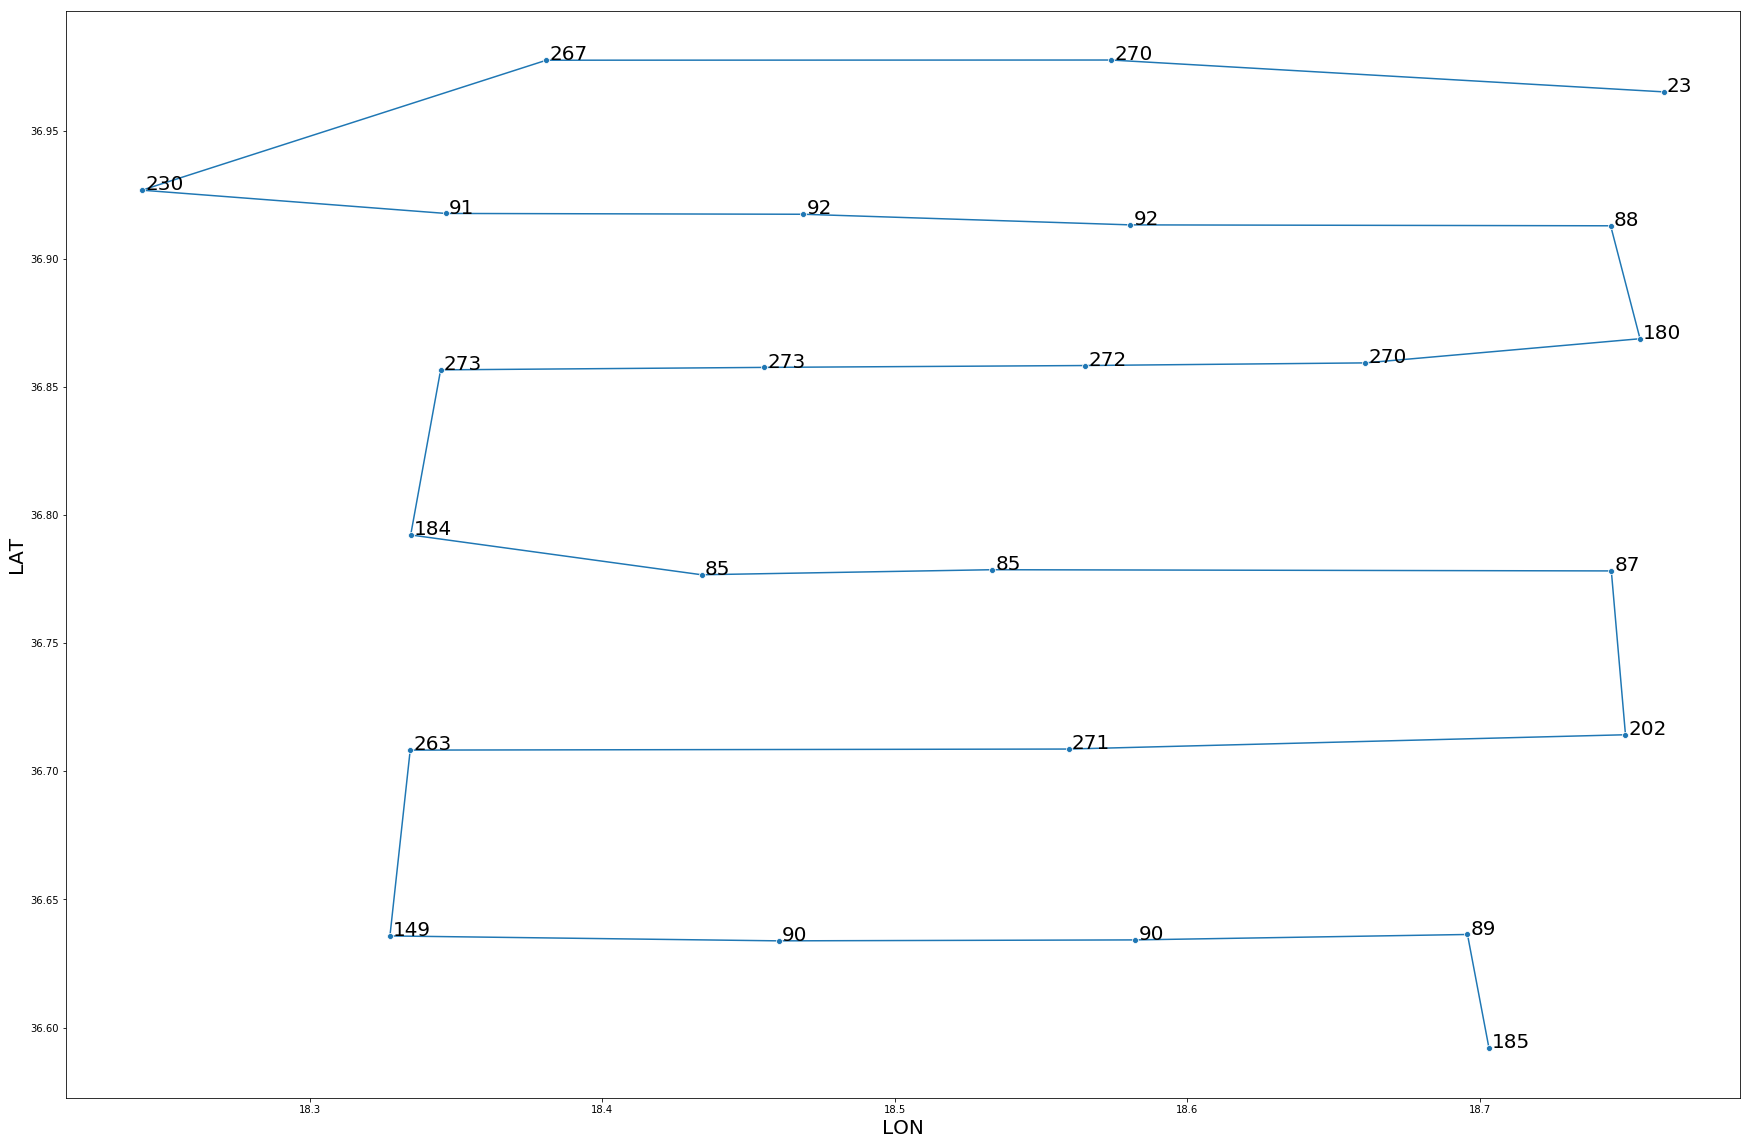

In [6]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 20)
ax.set_ylabel('Latitute', fontsize = 20.0) # Y label
ax.set_xlabel('Longitude ', fontsize = 20.0) # X label
data=real_data
#data=scalling_down_simple(data,train_test_options["split"])
data = scale_down_windowed(real_data,train_test_options["split"])
# Plot using Seaborn
sns.lineplot(x='LON', y='LAT', data=data, ax=ax,sort=False,marker="o")
for j, point in data.iterrows():
    ax.text(point['LON']+0.0011, point['LAT'], str(point['HEADING']),fontsize=20)